Epoch 0 
	Discriminator loss: 1.3789117336273193 
	Generator loss: 0.03187704086303711


TypeError: Invalid shape (128, 128, 12) for image data

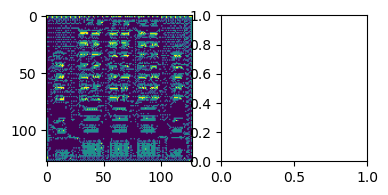

In [1]:
import torch.cuda
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.nn import functional as F

from mask2image import Mask2Image
from common.GANUNet import GAN_UNet
from common.PatchGAN import PatchGAN

import matplotlib.pyplot as plt

device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'

in_channels = 12
num_classes = 3

batch_size = 16
latent_dim = 100
epochs = 100
lr = 2e-4

target_transform = T.Compose([
    T.ToTensor(),
    T.Resize((128, 128)),
])

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

dataset = Mask2Image(img_dir="../../../data/cmp/train/img", postfix_img="jpg",
                     mask_dir="../../../data/cmp/train/ann", postfix_mask="png", num_cls=in_channels,
                     transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=batch_size)

test_dataset = Mask2Image(img_dir="../../../data/cmp/test/img", postfix_img="jpg",
                          mask_dir="../../../data/cmp/test/ann", postfix_mask="png", num_cls=in_channels,
                          transform=transform, target_transform=target_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

generator = GAN_UNet(in_channels=in_channels, num_classes=num_classes)
discriminator = PatchGAN(in_channels=num_classes)
generator.to(device)
discriminator.to(device)

gen_optimizer = torch.optim.AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
dis_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
    generator.train()
    discriminator.train()
    d_running_loss, g_running_loss = 0.0, 0.0

    for real_imgs, real_labels in dataloader:
        real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)

        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        fake_labels = generator(real_imgs)

        ## Discriminator
        verdict = discriminator(real_labels)
        real_loss = F.binary_cross_entropy(verdict,
                                           (torch.ones(verdict.shape) + 0.4 * torch.rand(verdict.shape) - 0.2).to(
                                               device))

        verdict = discriminator(generator(real_imgs).detach())
        fake_loss = F.binary_cross_entropy(verdict,
                                           (torch.zeros(verdict.shape) + 0.4 * torch.rand(verdict.shape) - 0.2).to(
                                               device))

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        dis_optimizer.step()

        ## Generator
        # Determine how well we fooled the discriminator
        verdict = discriminator(fake_labels)
        g_loss_disc = F.binary_cross_entropy(verdict,
                                             (torch.ones(verdict.shape) + 0.4 * torch.rand(verdict.shape) - 0.2).to(
                                                 device))

        # Determine how well the generator was able to produce something similar to the label
        g_loss_ce = 100 * F.l1_loss(fake_labels, real_labels)

        g_loss = g_loss_ce + g_loss_disc

        g_loss.backward()
        gen_optimizer.step()

        g_running_loss += g_loss / real_imgs.shape[0]
        d_running_loss += d_loss / real_imgs.shape[0]

    print(f"Epoch {epoch} \n\tDiscriminator loss: {g_running_loss / len(dataloader)} "
          f"\n\tGenerator loss: {d_running_loss / len(dataloader)}")

    for i, (real_imgs, real_labels) in enumerate(test_dataloader):
        plt.axis('off')
        generator.eval()

        plt.subplot(1, 3, 1)
        output = generator(real_imgs.to("cuda"))
        plt.imshow(torch.argmax(output, dim=1, keepdim=True)[0][0].cpu().detach().numpy())

        plt.subplot(1, 3, 2)
        plt.imshow(real_imgs[0].permute(1, 2, 0).cpu().numpy())

        plt.subplot(1, 3, 3)
        plt.imshow(torch.argmax(real_labels, dim=1, keepdim=True)[0][0].cpu().numpy())

        plt.show()